In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

MessageError: ignored

In [ ]:
# validation image
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Validation_Input.zip -O /content/drive/My\ Drive/lesion_detection/ISIC2018_Task1-2_Validation_Input.zip
# validation groundtruth task1
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1_Validation_GroundTruth.zip -O /content/drive/My\ Drive/lesion_detection/ISIC2018_Task1_Validation_GroundTruth.zip
# validation groundtruth task2
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task2_Validation_GroundTruth.zip -O /content/drive/My\ Drive/lesion_detection/ISIC2018_Task2_Validation_GroundTruth.zip

In [ ]:
# training image
# !wget https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task1-2_Training_Input.zip -O /content/drive/My\ Drive/lesion_detection/ISIC2018_Task1-2_Training_Input.zip

In [ ]:
# !unzip "/content/drive/My Drive/lesion_detection/ISIC2018_Task1-2_Training_Input.zip" -d "/content/drive/My Drive/lesion_detection/dataset/"

In [ ]:
!pip3 install ripser

     |████████████████████████████████| 72 kB 365 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 3.4 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455243 sha256=3c56064b8455f39351980fcfa538e6b53ebe2ce4d5fc0924d0fdf57affcc0dac
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=21e95924ca7d9e31ea931750bf453e846d26cf707cdaf488ad2f15b861db2786
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


In [ ]:
import numpy as np # handling arrays and general math
from scipy import sparse # working with sparse matrices
from ripser import lower_star_img # computing topological persistence of images
from scipy.sparse.csgraph import connected_components # compute connected components from sparse adjacency matrix
import cv2 # image processing library
import random # setting seeds
from scipy import ndimage # image smoothening
import PIL # imaging library
from scipy.ndimage.morphology import distance_transform_edt # compute closest background pixel
from skimage.measure import find_contours # find iso-valued contours in an image

In [ ]:
def img_to_sparseDM(img):
    """
    Compute a sparse distance matrix from the pixel entries of a single channel image for persistent homology
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    sparseDM: scipy.sparse (M * N, M * N)
        A sparse distance matrix representation of img
    """
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    
    # Make sure non-finite pixel entries get added at the end of the filtration
    img[img==-np.inf] = np.inf
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))
            
    return sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))


def connected_components_img(img):
    """
    Identify the connected components of an image
    
    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data
        Infinite entries correspond to empty pixels
        
    Returns
    -------
    img: ndarray (M, N)
        An array of single channel image data where each pixel value equals its modified lifespan
    """
    
    m, n = img.shape
    
    component = connected_components(img_to_sparseDM(img), directed=False)[1].reshape((m, n))
            
    return component


def smoothen(img, window_size):
    
    return(ndimage.uniform_filter(img.astype("float"), size=window_size))


def add_border(img, border_width):
    
    border_value = np.min(img) - 1 # make sure the pixels near the border reach te minimal value
    
    img[0:border_width,:] = border_value
    img[(img.shape[0] - border_width):img.shape[0],:] = border_value
    img[:,0:border_width] = border_value
    img[:,(img.shape[1] - border_width):img.shape[1]] = border_value

    return(img)


def lifetimes_from_dgm(dgm, tau=False):
    """
    Rotate a persistence diagram by 45 degrees, to indicate lifetimes by the y-coordinate
    
    Parameters
    ----------
    dgm: ndarray (K, 2)
        The persistence diagram to rotate
    tau: boolean
        Whether to return a threshold for indentifying connected components
        
    Returns
    -------
    dgm_lifetimes: ndarray (K, 2)
        The rotated diagram
        
    tau: float
        A threshold for identifying connected components 
        as those with finite oordinate above tau in the rotated diagram
    """ 
    
    dgm_lifetimes = np.vstack([dgm[:,0], dgm[:,1] - dgm[:,0]]).T
        
    if(tau):
      if(dgm.shape[0]>2):   
        dgm_for_tau = np.delete(dgm_lifetimes.copy(), np.where(dgm_lifetimes[:,1] == np.inf)[0], axis=0)
        sorted_points = dgm_for_tau[:,1]
        sorted_points[::-1].sort()
        dist_to_next = np.delete(sorted_points, len(sorted_points) - 1) - np.delete(sorted_points, 0)
        most_distant_to_next = np.argmax(dist_to_next)
        tau = (sorted_points[most_distant_to_next] + sorted_points[most_distant_to_next + 1]) / 2
      elif(dgm.shape[0]>1):
        dgm_for_tau = np.delete(dgm_lifetimes.copy(), np.where(dgm_lifetimes[:,1] == np.inf)[0], axis=0)
        tau = dgm_for_tau[0,1]-1
      else:
        print("Goodbye")
        
      return dgm_lifetimes, tau
    
    return dgm_lifetimes


def contour_segmentation(img, isovalue=None, return_contours=False):
    
    if isovalue is None:
        isovalue = np.mean(img)
    
    contours = find_contours(img, isovalue)
    img_segmented = np.zeros_like(img)
    for contour in contours:
        contour = np.int32(contour[:,range(1, -1, -1)]).reshape([1, contour.shape[0], contour.shape[1]])
        cv2.fillPoly(img_segmented, contour, 1)
        
    if return_contours:
        return img_segmented, contours
    
    return img_segmented


def topological_process_img(img, dgm=None, tau=None, window_size=None, border_width=None):
    
    return_modified = False
    if dgm is None:
        if window_size is not None:
            img = smoothen(img, window_size=window_size)
            return_modified = True
            
        if border_width is not None:
            img = add_border(img, border_width=border_width)
            return_modified = True
            
        dgm = lower_star_img(img)
    
    if tau is None:
        dgm_lifetimes, tau = lifetimes_from_dgm(dgm, tau=True)
        ####  show dgs &  tau
        
    else:
        dgm_lifetimes = lifetimes_from_dgm(dgm)
        
    idxs = np.where(np.logical_and(tau < dgm_lifetimes[:,1], dgm_lifetimes[:,1] < np.inf))[0]
    idxs = np.flip(idxs[np.argsort(dgm[idxs, 0])])
    didxs = np.zeros(0).astype("int")
    
    img_components = np.zeros_like(img)

    dist = np.zeros([len(idxs), img.shape[0], img.shape[1]])
    nearest_value = np.zeros([len(idxs), img.shape[0], img.shape[1]])

    for i, idx in enumerate(idxs):
        bidx = np.argmin(np.abs(img - dgm[idx, 0]))
        didxs = np.append(didxs, np.argmin(np.abs(img - dgm[idx, 1])))

        
        #img_temp = np.ones_like(img)
        img_temp = np.ones(img.shape)
        #img_temp2=img_temp.astype('Int32')
        img_temp[np.logical_or(img < dgm[idx, 0] - 0.01, dgm[idx, 1] - 0.01 < img)]= np.NaN
        component_at_idx = connected_components_img(img_temp)
        del(img_temp)

        component_at_idx = component_at_idx == component_at_idx[bidx // img.shape[1], bidx % img.shape[1]]
        if i > 0:
            didxs_in_component = idxs[np.where([component_at_idx[didx // img.shape[1], didx % img.shape[1]] 
                                                for didx in didxs])[0]]
            if len(didxs_in_component) > 0:
                component_at_idx[img > np.min(dgm[didxs_in_component, 1]) - 0.1] = False

        img_components[component_at_idx] = 1

        img_temp = np.ones_like(img)
        img_temp[component_at_idx] = 0
        dist[i,:,:], nearest_neighbor_temp = distance_transform_edt(img_temp, return_indices=True)
        nearest_value[i,:,:] = img[nearest_neighbor_temp[0], nearest_neighbor_temp[1]]
        del(img_temp, nearest_neighbor_temp)
        
    img_processed = np.zeros_like(img)
    all_components = img_components > 0
    img_processed[all_components] = img[all_components]
    with np.errstate(divide="ignore"):
        img_processed[~all_components] = np.sum(nearest_value / dist, axis=0)[~all_components] / \
                                            np.sum(1 / dist, axis=0)[~all_components]
     
    if return_modified:
        return {"modified": img, "components": img_components, "processed": img_processed}
    
    return {"components": img_components, "processed": img_processed}


def get_metrics(img_predicted, img_true):
    """
    Evaluate the performance 
    
    Parameters
    ----------
    img_predicted: ndarray (M, N)
        A binary segmented image
    img_true: ndarray (M, N)
        The true binary segmentation of the image
        
    Returns
    -------
    dictionary:
        A dictionary containing the accuracy, mcc, dice, and inclusion score for the performed segmentation
    """

    tp = np.sum(np.logical_and(img_true, img_predicted))
    fp = np.sum(np.logical_and(1 - img_true, img_predicted))
    tn = np.sum(np.logical_and(1 - img_true, 1 - img_predicted))
    fn = np.sum(np.logical_and(img_true,  1 - img_predicted))

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    mcc_denom = np.sqrt(tp + fp) * np.sqrt(tp + fn) * np.sqrt(tn + fp) * np.sqrt(tn + fn)
    if mcc_denom == 0:
        mcc = -1
    else:
        mcc = ((tp * tn) - (fp * fn)) / mcc_denom
    dice = 2 * tp / (2 * tp + fp + fn)
    inclusion = tp / (tp + fn)

    return {"accuracy": accuracy, "mcc": mcc, "dice": dice, "inclusion": inclusion}


In [ ]:
import matplotlib.image as mpimg # handling images
import os
import cv2
os.chdir('/content/drive/My Drive/lesion_detection') 

img = mpimg.imread(os.path.join("dataset","Validation_Input", "ISIC_0023371.jpg"))
sgm_truth = mpimg.imread(os.path.join("dataset","Task1_Validation_GroundTruth", "ISIC_0023371_segmentation.png"))

while(img.shape[1]>1000):
  img = cv2.resize(img,(0, 0), fx = 0.5, fy = 0.5)
  sgm_truth = cv2.resize(sgm_truth,(0, 0), fx = 0.5, fy = 0.5)

a=topological_process_img(img[:,:,0], window_size=25, border_width=25)
b=topological_process_img(img[:,:,0])

a['components']
a['processed']

array([[146.8944, 146.8944, 146.8944, ..., 146.784 , 146.784 , 146.784 ],
       [146.8944, 146.8944, 146.8944, ..., 146.784 , 146.784 , 146.784 ],
       [146.8944, 146.8944, 146.8944, ..., 146.784 , 146.784 , 146.784 ],
       ...,
       [146.9104, 146.8624, 146.8624, ..., 146.904 , 146.904 , 146.904 ],
       [146.8624, 146.8624, 146.8624, ..., 146.904 , 146.904 , 146.904 ],
       [146.8624, 146.8624, 146.8624, ..., 146.904 , 146.904 , 146.904 ]])

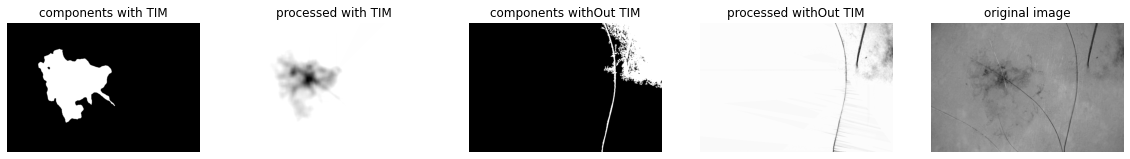

In [ ]:
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # handling images
import PIL # imaging library

fig, axes = plt.subplots(1, 5, figsize=(20, 10))
ax = axes.flatten()

ax[0].imshow(a['components'], cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("components with TIM", fontsize=12)

ax[1].imshow(a['processed'], cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("processed with TIM", fontsize=12)

ax[2].imshow(b['components'], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("components withOut TIM", fontsize=12)

ax[3].imshow(b['processed'], cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("processed withOut TIM", fontsize=12)

ax[4].imshow(img[:,:,0], cmap="gray")
ax[4].set_axis_off()
ax[4].set_title("original image", fontsize=12)


plt.show()

accuracy of problematic images 0.04253094438193501
accuracy of problematic images 0.08479707137398097
accuracy of problematic images 0.12563042018724524
accuracy of problematic images 0.16864522298177081
accuracy of problematic images 0.2117848603621773
accuracy of problematic images 0.25468290024909424
accuracy of problematic images 0.2972508306088655
accuracy of problematic images 0.339332912279212
accuracy of problematic images 0.3822444418202276
accuracy of problematic images 0.4249991817750792
accuracy of problematic images 0.4678409410559613
accuracy of problematic images 0.5099509971729222
accuracy of problematic images 0.5520209713258605
accuracy of problematic images 0.594382465749547
accuracy of problematic images 0.6362546837848165
accuracy of problematic images 0.6791408925816632
accuracy of problematic images 0.7220519798389379
accuracy of problematic images 0.7417742964150248
accuracy of problematic images 0.7842217044553894
accuracy of problematic images 0.82574175406193

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


accuracy of problematic images 0.8672351007876188
accuracy of problematic images 0.9105035340409143
accuracy of problematic images 0.9533565437493955


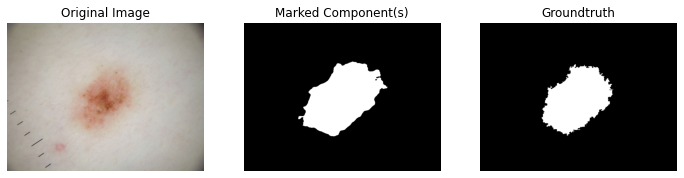

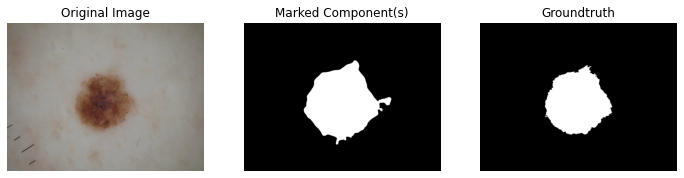

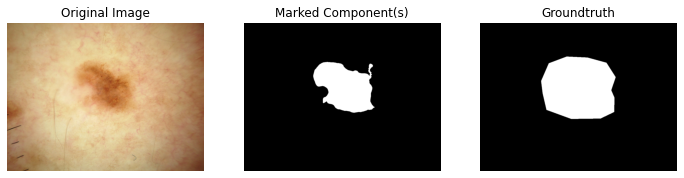

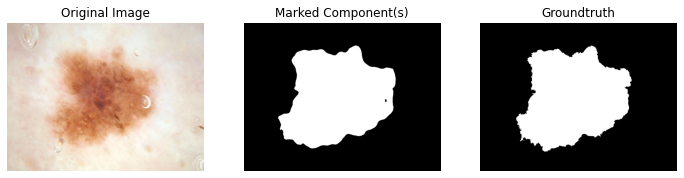

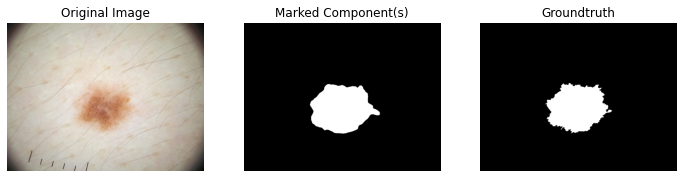

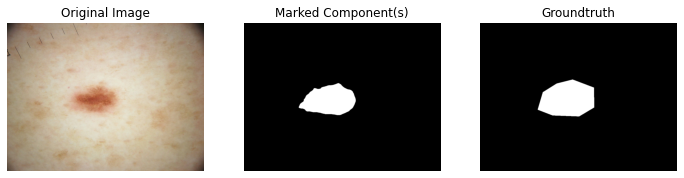

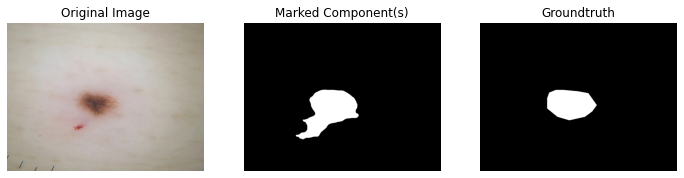

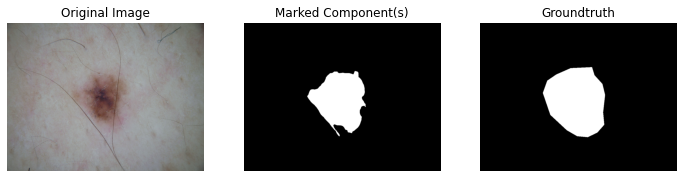

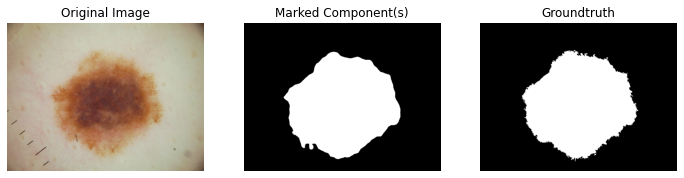

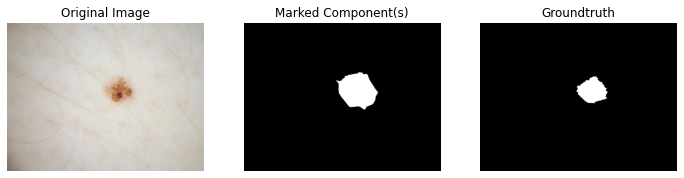

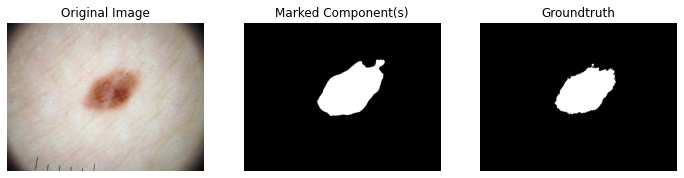

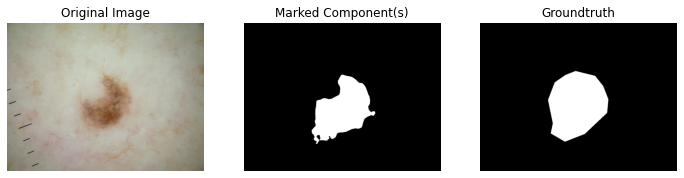

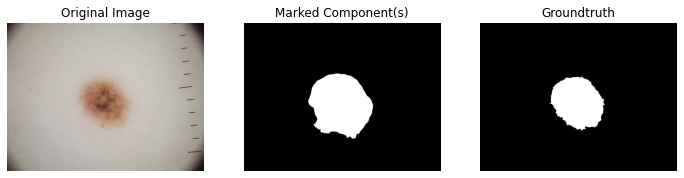

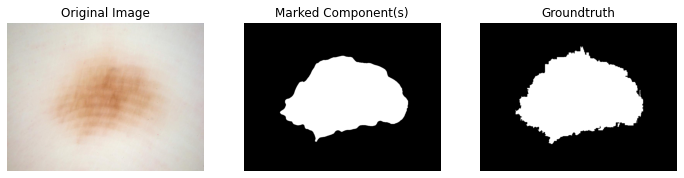

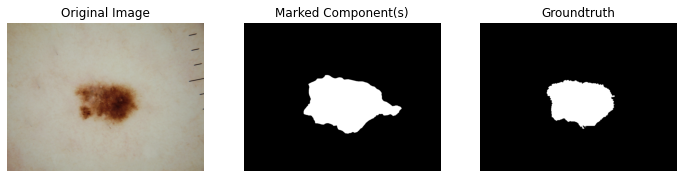

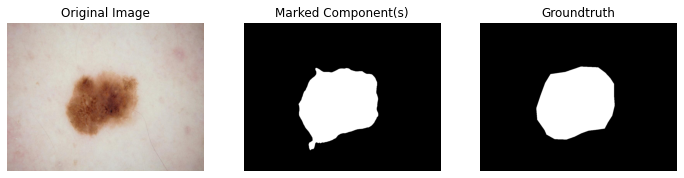

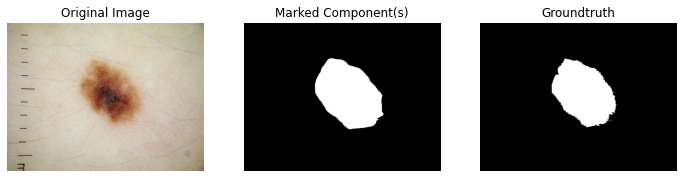

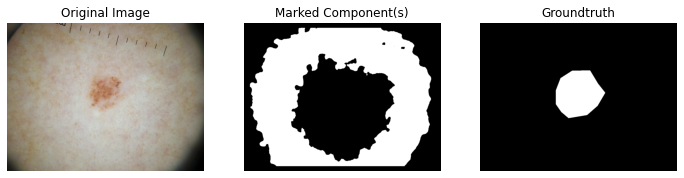

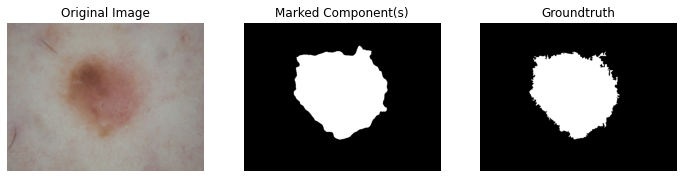

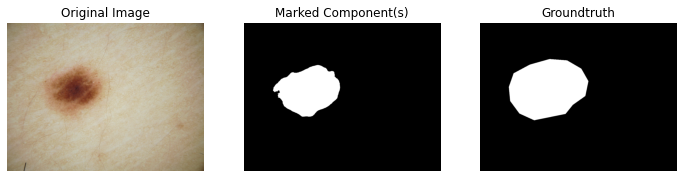

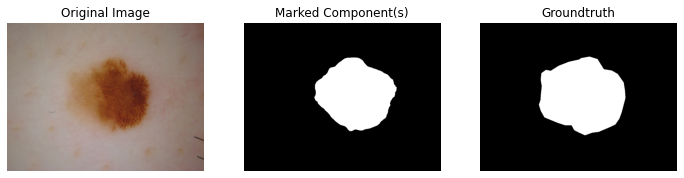

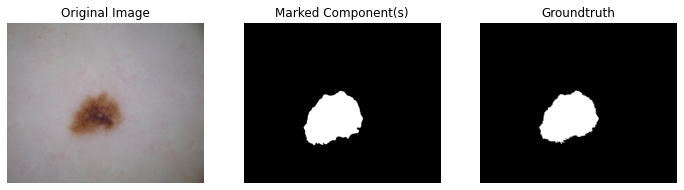

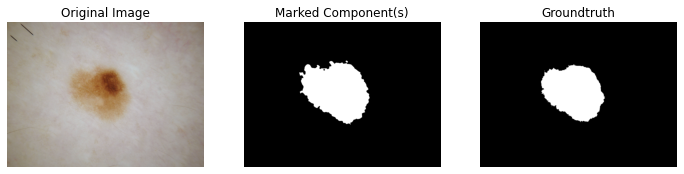

In [ ]:
import pickle
with open('TIP_problematic_lst.pkl', 'rb') as f:
  problematic_lst = pickle.load(f)

#img_name="ISIC_0009888.jpg"
import matplotlib.pyplot as plt

acc=0

for img_name in problematic_lst:############## Problematic

  sgm_name = img_name[:-4] + "_segmentation.png"
  img = mpimg.imread(os.path.join("dataset","ISIC2018_Task1-2_Training_Input", img_name))
  sgm_truth = mpimg.imread(os.path.join("dataset","ISIC2018_Task1_Training_GroundTruth", sgm_name))

  img_gray = np.asarray(PIL.Image.fromarray((img).astype(np.uint8)).convert("L")).copy().astype("float") # grayscale
  a =topological_process_img(img_gray, dgm=None, tau=None, window_size=25, border_width=25)
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  axes[0].imshow(img)
  axes[0].set_axis_off()
  axes[0].set_title("Original Image", fontsize=12)

  axes[1].imshow(a['components'], cmap="gray")
  axes[1].set_axis_off()
  axes[1].set_title("Marked Component(s)", fontsize=12)

  axes[2].imshow(sgm_truth, cmap="gray")
  axes[2].set_axis_off()
  axes[2].set_title("Groundtruth", fontsize=12)
  
  import TDAimgprocess as TIP
  acc += TIP.get_metrics(a["components"], sgm_truth)['accuracy']
  print("accuracy of problematic images" , acc/(len(problematic_lst)))

  #print(a['components'])

In [ ]:
len(problematic_lst)

23